In [3]:
import xarray as xr
import numpy as np
import dask.array as da
from sgkit.testing import simulate_genotype_call_dataset

### Task Optimization

In [125]:
import dask.array as da
import functools

ds = xr.Dataset(dict(
    x=xr.DataArray(da.array([[1, 2], [3, 4]]), dims=['row', 'col'])
))


def fn1(ds):
    return ds.x.sum(dim='row').rename('x_sum_row')

def fn2(ds):
    if 'x_sum_row' not in ds:
        ds['x_sum_row'] = ds.x.sum(dim='row')
    return ds.x_sum_row.sum(dim='col').rename('x_sum_row_col')
    
    
ds = ds.merge(fn1(ds))
ds = ds.merge(fn2(ds))
ds['x_merge'] = ds.x_sum_row + ds.x_sum_row_col
ds

<xarray.Dataset>
Dimensions:        (col: 2, row: 2)
Dimensions without coordinates: col, row
Data variables:
    x              (row, col) int64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    x_sum_row      (col) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    x_sum_row_col  int64 dask.array<chunksize=(), meta=np.ndarray>
    x_merge        (col) int64 dask.array<chunksize=(2,), meta=np.ndarray>

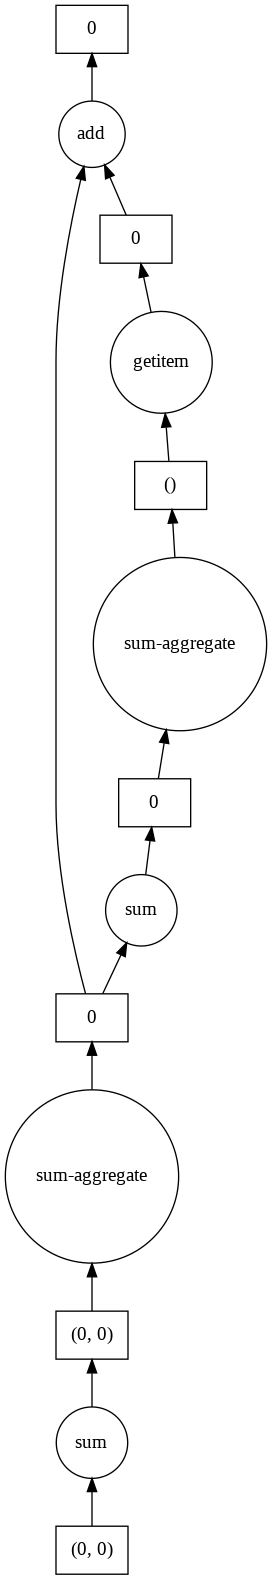

In [126]:
ds.x_merge.data.visualize()

### Segregating Variants

In [95]:
import xarray as xr
import numpy as np

calls = np.array([
    [[0, 0], [0, 0]],
    [[0, 0], [0, 1]],
    [[0, 2], [1, 1]],
    [[2, 2], [-1, -1]],
    [[2, -1], [2, -1]],
    [[2, -1], [1, -1]],
    [[2, -1], [-1, -1]],
    [[-1, -1], [-1, -1]],
])
dims = ('variants', 'samples', 'ploidy')
ds = xr.Dataset(dict(call_genotype=xr.DataArray(calls, dims=dims)))

is_segregating = (
    ds
    # This looks for any calls that are different from
    # a nan-aware mean (which would be the same w/ no segregation)
    .assign(cgo=ds.call_genotype, cgf=ds.call_genotype >= 0)
    .assign(cgm=lambda ds: ds.cgo.weighted(ds.cgf).mean(dim=('samples', 'ploidy')))
    .pipe(lambda ds: ds.cgf & (ds.cgo != ds.cgm))
    .any(dim=('samples', 'ploidy'))
)
is_segregating.values

array([False,  True,  True, False, False,  True, False, False])

### Allele Count Numba

In [35]:
import dask.array as da
import numpy as np
import xarray as xr
import numba
import os
from numba import njit
from xarray import DataArray, Dataset
from sgkit.testing import simulate_genotype_call_dataset

os.environ['NUMBA_DISABLE_JIT'] = '1'

n_alleles = 4
ds = simulate_genotype_call_dataset(n_variant=10000, n_sample=1000, n_ploidy=3, n_allele=n_alleles, seed=0)
ds['call_genotype'] = ds.call_genotype.chunk(chunks=(1000, 300))

In [32]:
@numba.guvectorize(['void(numba.int8[:], numba.int32[:], numba.int32[:])'], '(n),(k)->(k)')
def count_alleles(x, _, out):
    out[:] = 0
    for v in x:
        if v >= 0:
            out[v] += 1
            
def count_call_alleles(ds) -> DataArray:
    G = da.asarray(ds.call_genotype)
    O = da.empty(G.shape[:2] + (ds.dims['alleles'],), dtype='int32')
    O = O.rechunk(G.chunks[:2] + (-1,))
    return xr.DataArray(
        count_alleles(G, O),
        dims=('variants', 'samples', 'alleles'),
        name='call_allele_count'
    )

def count_call_alleles2(ds):
    n = ds.dims['alleles'] + 1
    return da.apply_along_axis(np.bincount, 2, ds.call_genotype + 1, shape=(n,), minlength=n)[..., 1:] 

def count_variant_alleles(ds) -> DataArray:
    return (
        count_call_alleles(ds)
        .sum(dim='samples')
        .rename('variant_allele_count')
    )
v = count_call_alleles(ds).data.compute()

In [20]:
np.testing.assert_array_equal(v, count_call_alleles2(ds).compute())

In [2]:
def count_call_alleles(ds):
    n = ds.dims['alleles'] + 1
    return da.apply_along_axis(np.bincount, 2, ds.call_genotype + 1, shape=(n,), minlength=n)[..., 1:] 

In [4]:
%%time
count_call_alleles(ds).compute().shape

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.4 µs


In [335]:
def ct(x):
    return np.bincount(x + 1, minlength=n_alleles + 1)[1:]
gufoo = da.gufunc(ct, signature="(i)->(k)", output_dtypes='int32', vectorize=True, output_sizes=dict(k=n_alleles))

In [ ]:
%%time
gufoo(ds.call_genotype.data).compute().shape

In [ ]:
@numba.guvectorize(['void(numba.int8[:], numba.int32[:])'], '(n),(k)')
def allele_count_fn(x, out):
    for _, i in np.ndenumerate(x):
        if i >= 0:
            out[i] += 1

In [ ]:
def count_call_alleles(ds):
    x = da.asarray(ds.call_genotype)
    def block_fn(x):
        out = np.zeros(x.shape[:2] + (n_alleles,), dtype='int32')
        allele_count_fn(x, out)
        return out
    return da.map_blocks(block_fn, x, chunks=x.chunks[:2] + (n_alleles,), dtype='int32')
r = count_call_alleles(ds)
r

In [ ]:
%%time
count_call_alleles(ds).compute().shape

In [ ]:
x = da.asarray(ds.call_genotype)
out = da.zeros(x.shape[:2] + (n_alleles,), dtype='int32').rechunk(x.chunks[:2] + (-1,))
def block_fn(x, out):
    allele_count_fn(x, out)
    return out
r = da.map_blocks(block_fn, x, out, chunks=out.chunks, dtype='int32')
r

In [26]:
%%time
x = da.asarray(ds.call_genotype)
o = da.zeros(x.shape[:2] + (n_alleles,), dtype='int32')
o = o.rechunk(x.chunks[:2] + (-1,))
r = allele_count_fn(x, o)
r.compute().shape

CPU times: user 317 ms, sys: 230 ms, total: 547 ms
Wall time: 150 ms


(10000, 1000, 4)

In [27]:
# variant_allele_count
r.sum(axis=1)

dask.array<sum-aggregate, shape=(10000, 4), dtype=int64, chunksize=(1000, 4), chunktype=numpy.ndarray>